In [1]:
import matplotlib.pyplot as plt

%matplotlib inline

# Clothoid

A clothoid, also known as an Euler spiral, is a curve with the property that its curvature is proportional to its length. In other words, if the curve is described as a prametric equation with parameter $t$, then:

$$
\kappa(t) \cdot L(t) = A^2,
$$

where $\kappa(t)$ is the curvature and $L(t)$ is the length and $A$ is some constant.

Such a curve can be defined in terms of the fresnel integrals as:

$$
x(t) = aC(t), ~ y(t) = aS(t),
$$

where the Fresnel integrals are:

$$
S(t) = \int_0^t \text{sin}(u^2) du \\
C(t) = \int_0^t \text{cos}(u^2) du
$$

Often _normalised_ versions are used that scale the arguments of the integrals such that:

$$
S(t) = \int_0^t \text{sin}(\pi u^2 / 2) du \\
C(t) = \int_0^t \text{cos}(\pi u^2 / 2) du
$$

This is what the Scipy implementation of the Fresnel integrals uses, and what will be used in the remainder of this notebook as well. The below shows what such a curve looks like.

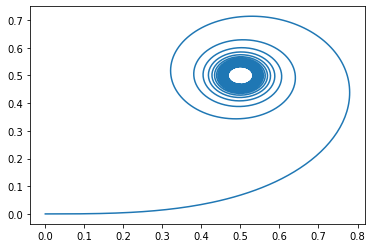

In [2]:
import math
import numpy as np
from scipy.special import fresnel

def clothoid(t, num=50):
    s, c = fresnel(np.linspace(0, t, num))
    return c, s

p = plt.plot(*clothoid(10, 1000))

The curve indeed increases curvature and angle with the x axis continuously, in the following way:

$$
\kappa(t) = \frac{\pi}{a} t \\
\theta(t) = \frac{\pi}{2} t^2
$$

The tangent vector at any point is then $(\text{cos}(\theta(t)), \text{sin}(\theta(t))^\top$. The following visualises these for the clothoid up to $t = 2$.

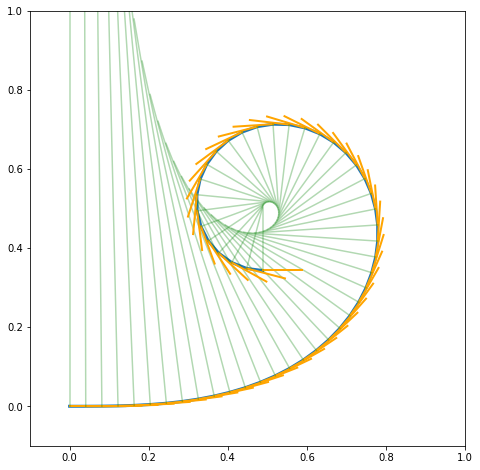

In [3]:
def curvature(t):
    return math.pi * t

def angle(t):
    return math.pi / 2 * t ** 2

def tangent(t):
    th = angle(t)
    return np.stack([np.cos(th), np.sin(th)])

def perpendicular(t):
    th = angle(t)
    return np.stack([-np.sin(th), np.cos(th)])

t_max = 2
fig, ax = plt.subplots(figsize=(8, 8))

# Smooth clothoid
ax.plot(*clothoid(t_max), linewidth=3)
ax.set_xlim((-0.1, 1))
ax.set_ylim((-0.1, 1))
ax.set_aspect("equal")
# Subsampled clothoid
n_samples = 50
xs, ys = clothoid(t_max, n_samples)
ts = np.linspace(0, t_max, n_samples)

kappas = curvature(ts)
thetas = angle(ts)
tangents = tangent(ts)
perps = perpendicular(ts)

for x, y, kappa, theta, tangent, perp in zip(xs, ys, kappas, thetas, tangents.T, perps.T):
    ax.plot([x, x + tangent[0] * 0.1], [y, y + tangent[1] * 0.1], c='orange', linewidth=2)
    radius = 1.0 / (kappa + 1e-9)  # prevent divide by 0
    ax.plot([x, x + perp[0] * radius], [y, y + perp[1] * radius], c='green', alpha=0.3)


Clothoids are useful when designing roads and rail tracks. They can provide smooth transitions between stretches with different curvature. For instance, if a road or track immediately transitions from a straight segment to a bend with a constant curvature, so a circular arc, then there is a very sudden jump in rotational speed. A driver would have to turn their steering wheel immediately from zero to the amount that achieves the correct curvature.

By placing a clothoid segment before the curve, the curvature increases linearly if the vehicle maintains constant linear speed, resulting in a smooth steering action.

The following is an example, where a 90 degree turn is achieved using two clothoid sections and a circular arc.

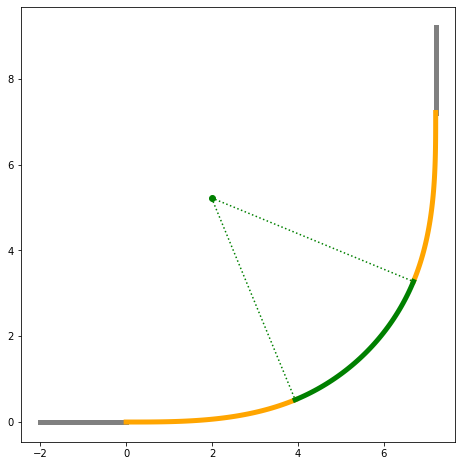

In [4]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot([-2, 0], [0, 0], c='grey', linewidth=5, zorder=1)
ax.set_aspect("equal")

# Scale of the clothoid
a = 8
t = 0.5
cx, cy = clothoid(t)
cx = a * cx
cy = a * cy
ax.plot(cx, cy, c='orange', linewidth=5, zorder=2)

# Determine parameters at end of clothoid
# Scaling up means smoothing out, so lower curvature
theta = angle(t)
kappa = curvature(t) / a
radius = 1 / kappa
perp = perpendicular(t)

# Determine circular arc parameters
circ_centre = np.array([cx[-1], cy[-1]]) + radius * perp
ax.plot(*circ_centre, 'o', c='green', zorder=3)
circ_start_angle = -math.pi / 2 + theta
circ_end_angle = -theta
ts = np.linspace(circ_start_angle, circ_end_angle)
arc = (
    circ_centre.reshape((2, 1)) 
    + radius * np.stack([np.cos(ts), np.sin(ts)])
).T
ax.plot(*arc.T, linewidth=5, c='green', zorder=3)
ax.plot(*zip(circ_centre, arc[0]), ':', c='green', zorder=3)
ax.plot(*zip(circ_centre, arc[-1]), ':', c='green', zorder=3)
# ax.plot([circ_centre[0], arc[0, 0]], [circ_centre[1], arc[0,1]], c='k')

# Mirror clothoid diagonally around arc centre
cx2 = -cy
cy2 = -cx
delta = circ_centre[1] + circ_centre[0]
ax.plot(delta + cx2, delta + cy2, c='orange', linewidth=5, zorder=2)
ax.plot([delta, delta], [delta, delta + 2], c='grey', linewidth=5, zorder=1)

The above derived the start and end points of each section based on a fixed scale and length of the clothoid segments. In real world planning scenarios, an inverse problem is of more interest: given two segments with fixed endpoints and direction, find a combination of segments that connect them smoothly.

Let us first assume a relatively straightforward case, where the segments to be connected are straight (have zero curvature) and their extensions meet at a point that is equidistant from their ends. The following shows this situation.

(array([0, 0]), array([1.46446609, 3.53553391]), array([5, 0]))

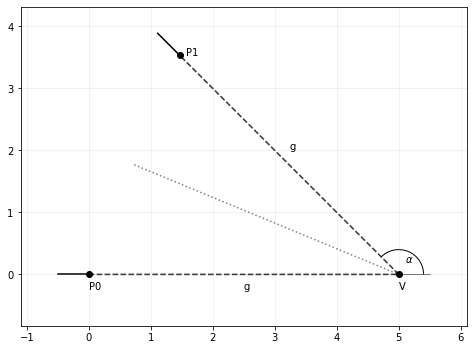

In [5]:
import matplotlib.patches as mpatches

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    return v / norm

def plot_join_problem(g, alpha, ax, labels=True):
    ax.set_aspect("equal")
    ax.margins(0.1)
    ax.grid(alpha=0.2)
    p0 = np.array((0, 0))
    v = np.array((g, 0))
    p1 = np.array((g + g * math.cos(alpha), g * math.sin(alpha)))
    
    # Ends of segments to join
    ax.plot(*zip(p0, p0 - normalize(v - p0) * 0.5), c='k')
    ax.plot(*zip(p1, p1 - normalize(v - p1) * 0.5), c='k')

    # Extensions and point where they meet
    ax.plot(*zip(p0, v, p1), '--', c='k', alpha=.5)
    ax.plot(*zip(p0, v, p1), '--', c='k', alpha=.5)
    ax.plot(*zip((p0 + p1) / 2, v), ':', c='k', alpha=.5)
    ax.plot(*zip(p0, v, p1), 'o', c='k')
    
    # Angle alpha
    ax.plot([g, g+0.5], [0, 0], c='k', linewidth=.5)
    a = mpatches.Arc(v, 0.8, 0.8, theta2=alpha/math.pi * 180)
    ax.add_patch(a)

    if labels:
        ax.text(*(p0 + (0, -0.25)) , s="P0")
        ax.text(*(p1 + (0.1, 0)) , s="P1")
        ax.text(*(v + (0, -0.25)) , s="V")
        ax.text(*((p0 + v) / 2 + (0, -0.25)), s="g")
        ax.text(*((p1 + v) / 2 + (0, +0.25)), s="g")
        ax.text(g + 0.1, 0.2, "$\\alpha$")

    return p0, p1, v

fig, ax = plt.subplots(figsize=(8, 8))
plot_join_problem(5, 0.75 * math.pi, ax)

We will first find a solution that connects the segments just using clothoids. We need to determine the clothoid from point P0 up to the bisector shown as a dotted line above, after which we can simply mirror that to arrive at the second part of the joint.

To achieve continuity, the tangents of the clothoids where they meet should be perpendicular to the bisector, which gives an angle $\theta(t) = \frac{1}{2} \alpha$. Then we can find the scaling factor $a$ by realizing that $aC(t) + aS(t) \cdot \text{tan} \theta(t) = g$, so that $a = \frac{g}{C(t) + S(t) \cdot \text{tan} \theta(t)}$.

The following shows this solution.

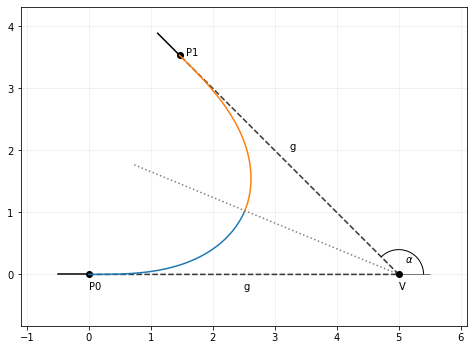

In [6]:
def solve_symmetric_join(g, alpha):
    p0 = np.array((0, 0))
    v = np.array((g, 0))
    p1 = np.array((g + g * math.cos(alpha), g * math.sin(alpha)))

    # Find angle at clothoid end and equation parameter t
    theta = alpha / 2
    t = math.sqrt(theta * 2 / math.pi)
    
    # First segment
    cx1, cy1 = clothoid(t)
    a = g / (cx1[-1] + cy1[-1] * math.tan(theta))
    cx1 = a * cx1
    cy1 = a * cy1
    
    # Second segment
    # Mirror, rotate and translate
    cx2 = cx1
    cy2 = -cy1
    alpha_ = alpha - math.pi
    cx2, cy2 = (
        p1[0] + np.cos(alpha_) * cx2 - np.sin(alpha_) * cy2,
        p1[1] + np.sin(alpha_) * cx2 + np.cos(alpha_) * cy2
    )
    
    return ((cx1, cy1), (cx2, cy2))


g = 5
alpha = 0.75 * math.pi


fig, ax = plt.subplots(figsize=(8, 8))
plot_join_problem(g, alpha, ax)
((cx1, cy1), (cx2, cy2)) = solve_symmetric_join(g, alpha)


plt.plot(cx1, cy1)
plt.plot(cx2, cy2)

We can apply this to any random angle betwwon $0$ and $\pi$.

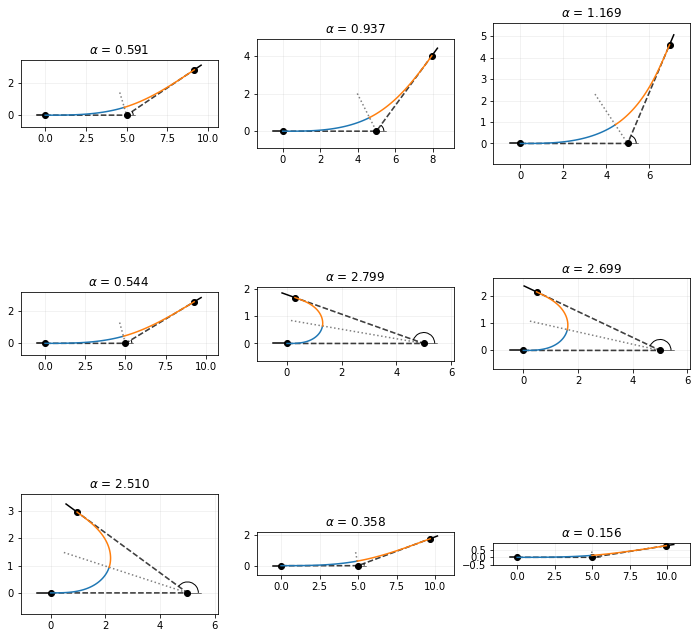

In [7]:
import random

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for ax in np.ravel(axes):
    g = 5
    alpha = random.random() * math.pi
    
    plot_join_problem(g, alpha, ax, labels=False)
    ((cx1, cy1), (cx2, cy2)) = solve_symmetric_join(g, alpha)

    ax.plot(cx1, cy1)
    ax.plot(cx2, cy2)
    ax.set_title(f"$\\alpha$ = {alpha:.3f}")